# Number of Errors
Authors: [RedSkittleFox](https://github.com/RedSkittleFox), [DJAltair](https://github.com/DJAltair)

# Get the Data

In [29]:
import os
import pandas as pd
import numpy as np 

critical_errors_data : pd.DataFrame = pd.read_csv(os.path.join("data", "critical_errors.csv"), sep=",")
critical_errors_data.head()

,Month,Errors
0,1,1
1,2,0
2,3,0
3,4,0
4,5,0


In [30]:
critical_errors_data.describe()

,Month,Errors
count,93.000000,93.00000
mean,47.000000,2.83871
std,26.990739,3.92398
min,1.000000,0.00000
25%,24.000000,0.00000
50%,47.000000,1.00000
75%,70.000000,4.00000
max,93.000000,19.00000


# Data Preparation

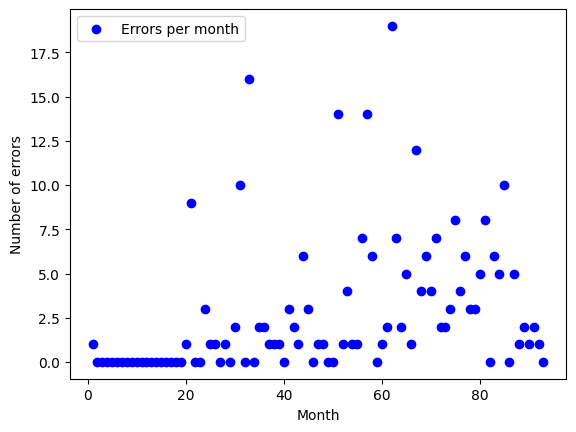

In [31]:
import matplotlib.pyplot as plt
plt.scatter(critical_errors_data["Month"], critical_errors_data["Errors"], color='b', label="Errors per month");
plt.xlabel("Month")
plt.ylabel("Number of errors")
plt.legend();

We generate new variable called `Cumulative Errors` which expresses how many errors have accumulated since the program deployment till the given month.

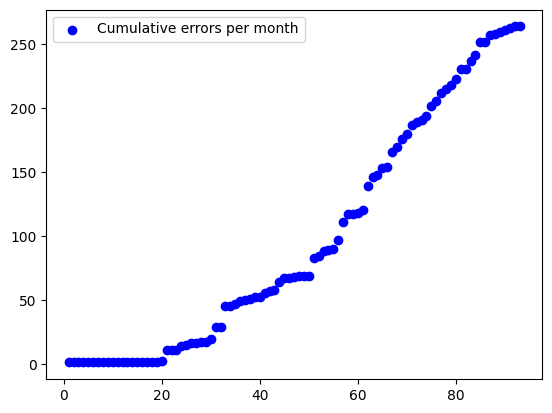

In [32]:
critical_errors_data["Cumulative Errors"] = critical_errors_data["Errors"]
for i in range(1, len(critical_errors_data["Errors"])):
    critical_errors_data["Cumulative Errors"][i] = critical_errors_data["Cumulative Errors"][i] + critical_errors_data["Cumulative Errors"][i - 1]

plt.scatter(critical_errors_data["Month"], critical_errors_data["Cumulative Errors"], color='b', label="Cumulative errors per month")
plt.legend()
plt.show()

# Linear Model
We start by preparing the linear regression model.
$$
\text{Cumulative errors}(\text{Month}) = 3.2562293 \cdot \text{Month} - 55.0320243
$$

$RMSE = 22.52615$

$R^2 = 0.93359$

coef = [3.2562293]
intercept = -55.03202431042537
R2 = 0.933593642138264 | RMSE = 22.526152904621625


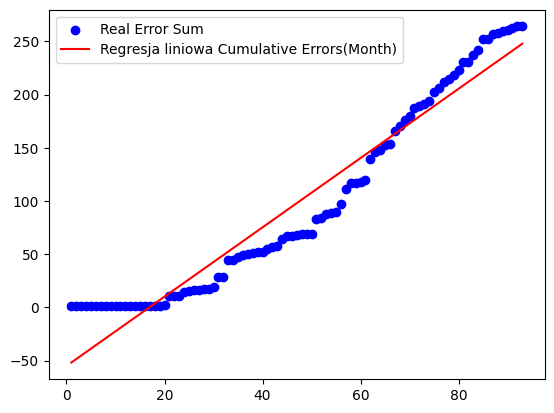

In [33]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

X = critical_errors_data[["Month"]].copy()
Y = critical_errors_data["Cumulative Errors"].copy()

lin_reg = LinearRegression()
lin_reg.fit(X, Y)
Y_predicted = lin_reg.predict(X)
print(f"coef = {lin_reg.coef_}")
print(f"intercept = {lin_reg.intercept_}")

X_lin = X.copy()
Y_lin = Y_predicted.copy()

R2 = r2_score(Y_predicted, Y)
RMSE = np.sqrt(mean_squared_error(Y_predicted, Y))

print(f"R2 = {R2} | RMSE = {RMSE}")

#rozmiar kropki
plt.scatter(critical_errors_data["Month"], critical_errors_data["Cumulative Errors"], color="b", label="Real Error Sum")
plt.plot(X, Y_predicted, color='r', label="Regresja liniowa Cumulative Errors(Month)")
plt.legend()
plt.show()

# Logistic Model
Logistic regression is expressed with function
$$
\hat y_t = \frac{k}{1 + b \cdot \exp(-at) }
$$

We use scipy's optimized, which uses L-BFGS-B method to estimate parameters $(k, a, b)$. The minimized error function is expressed as follows
$$
f(k, a, t) = \sum_{t = 1}^n(\hat y_t - y_t)^2 = \sum_{t = 1}^n(\frac{k}{1 + b \cdot \exp(-at)} - y_t)^2
$$
We use Hotteling's estimation method to estimate the starting point for the optimized.

In [34]:
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.optimize import minimize
import warnings

class OneClassLogisticRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, k = None, b = None, a = None, method="L-BFGS-B"):
        self.k = k
        self.a = a
        self.b = b
        self.method = method

    def fit(self, X, y):
        if len(X.shape) != 2 or X.shape[1] != 1:
            raise Exception("Invalid array shape, use .reshape(-1, 1)")
        
        X = np.double(np.asarray(X).ravel())

        # Hotteling method to estimate the starting point
        if self.k == None or self.a[1] == None or self.b[2] == None:
            n = len(y)
            y_avg = np.average(y)
            dy = y.copy()
            dy[0] = 0
            for i in range(1, len(y)):
                dy[i] = ( y[i] - y[i - 1] ) / y[i]

            dy = dy[1:]
            Y = y[1:]
            x = X[1:]

            dy_avg = (1 / (n - 1) * np.sum(dy))

            self.a = dy_avg - (np.sum( ( Y - y_avg) * (dy - (dy_avg))) ) / np.sum((Y - y_avg)**2) * y_avg
            self.k = -self.a * np.sum((Y - y_avg) ** 2) / np.sum( ( Y - y_avg) * (dy - dy_avg))
            self.b = np.exp(( np.sum( np.log(self.k / y - 1) ) + self.a * np.sum(X) ) / n)
            self.h_a = self.a
            self.h_k = self.k
            self.h_b = self.b
            
        params = [self.k, self.a, self.b]

        def constraint(params):
            k = params[0]
            a = params[1]
            b = params[2]
            y_predicted = np.exp(-a * X)
            if(np.isnan(y_predicted).any()):
                return 0
            else:
                return 1

        def evaluate(params):
            k = params[0]
            a = params[1]
            b = params[2]
            y_predicted = k / (1.0 + b * np.exp(-a * X))
            
            mse = mean_squared_error(y_true=y, y_pred=y_predicted)
            return mse

        warnings.filterwarnings('ignore')
        result = minimize(evaluate, params, method=self.method)

        self.k = result.x[0]
        self.a = result.x[1]
        self.b = result.x[2]

        return self

    def predict(self, X):
        return self.k / (1.0 + self.b * np.exp(-self.a * X))
    
    def hotelling_predict(self, X):
        return self.h_k / (1.0 + self.h_b * np.exp(-self.h_a * X))

Hottelling  | k = 318.2293155927951 | a = 0.06649497935443306 | b = 130.2115047444905
Final       | k = 310.3841142922193 | a = 0.06868055568943261 | b = 91.33511731675094
R2 = 0.9954729178225207 | RMSE = 5.997974849775009


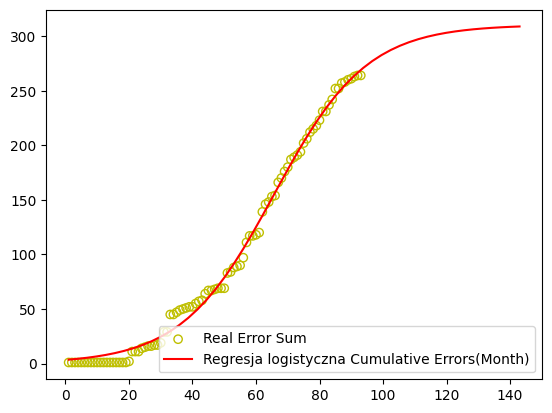

In [35]:
from itertools import chain

X = critical_errors_data[["Month"]].copy()
Y = critical_errors_data["Cumulative Errors"].copy()

one_log_regression = OneClassLogisticRegression()
one_log_regression.fit(X, Y)

Y_predicted = one_log_regression.predict(X)

R2 = r2_score(Y_predicted, Y)
RMSE = np.sqrt(mean_squared_error(Y_predicted, Y))

print(f"Hottelling  | k = {one_log_regression.h_k} | a = {one_log_regression.h_a} | b = {one_log_regression.h_b}")
print(f"Final       | k = {one_log_regression.k} | a = {one_log_regression.a} | b = {one_log_regression.b}")

print(f"R2 = {R2} | RMSE = {RMSE}")

plt.scatter(critical_errors_data["Month"], critical_errors_data["Cumulative Errors"], color="y", label="Real Error Sum", marker="o", facecolors='none')
space = np.linspace(X.min(), X.max()+50)
Xg = pd.DataFrame({"Month" : list(chain.from_iterable(np.asarray(space).tolist())) })
Yg = one_log_regression.predict(Xg)

Xg2 = pd.DataFrame({"Month" : list(chain.from_iterable(np.asarray(space).tolist())) })
Yg2 = one_log_regression.hotelling_predict(Xg2)

plt.plot(Xg, Yg, color='r', label="Regresja logistyczna Cumulative Errors(Month)")
#plt.plot(Xg2, Yg2, color='b', label="Regresja liniowa (Hotelling) Cumulative Errors(Month)")
plt.legend()
plt.show()

The problem of determining logistic regression coefficients proved to be non-trivial. We made several attempts to determine it - using the brute-force method and then the optimizer and selecting random optimizer starting points proved unsuccessful. Only the determination of the starting points using the Hotteling approximation gave a satisfactory result. To illustrate the accuracy of logistic regression, we created a linear regression model. The combination of the above models shows how well the logistic (sigmoid) model fits the data. In addition, our unconventional optimization method also allowed us to test the accuracy of the Hotteling method.

R2 = 0.9954728789079789 | RMSE = 5.997975140343347


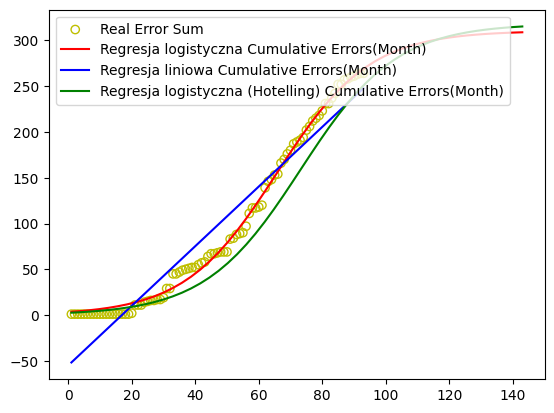

In [36]:
def log_predict1(X_):
    return 310.396656658546 / (1 + 91.3185198718092 * np.exp(-(0.0686764526105394 * X_)))

Y_real = critical_errors_data["Cumulative Errors"]
Y_predicted = log_predict1(X)

R2 = r2_score(Y_predicted, Y_real)
RMSE = np.sqrt(mean_squared_error(Y_predicted, Y_real))

print(f"R2 = {R2} | RMSE = {RMSE}")

plt.scatter(critical_errors_data["Month"], critical_errors_data["Cumulative Errors"], color="y", label="Real Error Sum", marker="o", facecolors='none')
space = np.linspace(X.min(), X.max())
Xg1 = pd.DataFrame({"Month" : list(chain.from_iterable(np.asarray(space).tolist())) })
Yg1 = log_predict1(Xg)
plt.plot(Xg, Yg, color='r', label="Regresja logistyczna Cumulative Errors(Month)")
plt.plot(X_lin, Y_lin, color='b', label="Regresja liniowa Cumulative Errors(Month)")
#plt.plot(Xg1, Yg1, color='g', label="Regresja liniowa (EXCEL) Cumulative Errors(Month)", linestyle='dashed')
plt.plot(Xg2, Yg2, color='g', label="Regresja logistyczna (Hotelling) Cumulative Errors(Month)")
plt.legend()
plt.show()

As can be seen in the graph (green curve), the curve fits the data relatively well but is not as well fitted as the curve determined by numerical methods.